### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import sys
import time
import xgboost as xgb
import seaborn as sns
import pandas as pd
from preprocess import clahe, sectioning, sectioning_valid, display_sections, hist_equalization
from feature_extraction import extract_features
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sys.path.append('../')
from load_images import load

In [2]:
img_size = (512, 512)
X, y, masks = load(img_size)

<function matplotlib.pyplot.show(close=None, block=None)>

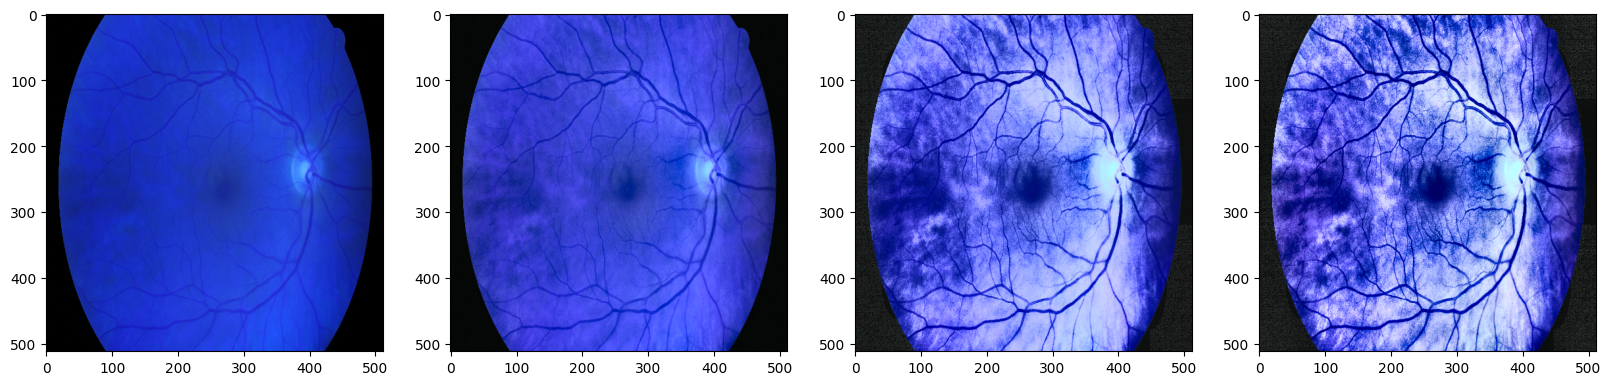

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(20,15))
ax[0].imshow(X[1], cmap='gray')
ax[1].imshow(clahe(X[1]), cmap='gray')
ax[2].imshow(hist_equalization(clahe(X[1])) , cmap='gray')
ax[3].imshow(clahe(hist_equalization(clahe(X[1]))) , cmap='gray')
plt.show

### Split image to NxN sections
Above code is not used anymore

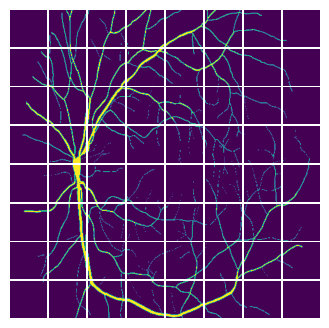

In [4]:
N = 64
sections, targets, section_size, target_size = sectioning(clahe(X[0]), y[0], N)
display_sections(targets, target_size, N)
# display_sections(sections, section_size, N)

This is proper sectioning. We will pass this sections to a classifier later:

In [19]:
num_img = 3
N = 5
sections = np.zeros((num_img, img_size[0]*img_size[1], N, N, 3))
targets = np.zeros((num_img, img_size[0]*img_size[1]))
random_imgs_indx = [random.randint(0, len(X)-1) for _ in range(num_img)]

for i, indx in enumerate(random_imgs_indx):
    sections[i] = sectioning_valid(clahe(X[indx]), N)
    _, target = cv2.threshold(y[indx], 128, 1, cv2.THRESH_BINARY)
    targets[i] = target.flatten()
    
sections = sections.reshape(num_img*img_size[0]*img_size[1], N, N, 3)
targets = targets.reshape(num_img*img_size[0]*img_size[1])

512 512
512 512
512 512


In [20]:
sections.shape, targets.shape

((786432, 5, 5, 3), (786432,))

### Feature Extraction

In [21]:
sample_feature_v = extract_features(sections[58287])
sample_feature_v

array([ 5.80000000e+01,  5.98400000e+01,  1.86080000e+02,  7.93977330e+00,
        1.02593567e+01,  9.28620482e+00,  1.60788889e-03,  2.13497011e-09,
        2.69134238e-12,  3.11972110e-12,  6.46455973e-24, -1.26721383e-16,
       -6.31879666e-24])

### Convert sections to feature vectors

In [22]:
num_features = len(sample_feature_v)
section_features = np.zeros((sections.shape[0], num_features))

start = time.time()
for i in range(sections.shape[0]):
    section_features[i] = extract_features(sections[i])
stop = time.time()

duration = stop - start
duration # ~3s per image

8.660833597183228

In [23]:
X_train, X_test, y_train, y_test = train_test_split(section_features, targets, test_size=0.2, shuffle=True)

### Testing classifiers

In [24]:
f1_scores = {}
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### K-Nearest Neigbors

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
f1_scores['knn'] = f1_score(y_test, knn.predict(X_test))

#### Logistic Regression

In [26]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
f1_scores['logreg'] = f1_score(y_test, logreg.predict(X_test))

/home/kamil/anaconda3/envs/data_science/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Naive Bayes

In [27]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
f1_scores['bayes'] = f1_score(y_test, bayes.predict(X_test))

#### AdaBoost

In [28]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
f1_scores['ada'] =  f1_score(y_test, ada.predict(X_test))

#### Gradient Boosting Classifier

In [29]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
f1_scores['gbc'] = f1_score(y_test, gbc.predict(X_test))

#### Decision tree

In [30]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
f1_scores['tree'] = f1_score(y_test, tree_clf.predict(X_test))

#### Random forest

In [31]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
f1_scores['forest'] = f1_score(y_test, forest_clf.predict(X_test))

#### XGBoost

In [32]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
f1_scores['xgb'] = f1_score(y_test, xgb_clf.predict(X_test))

### Different methods comparison

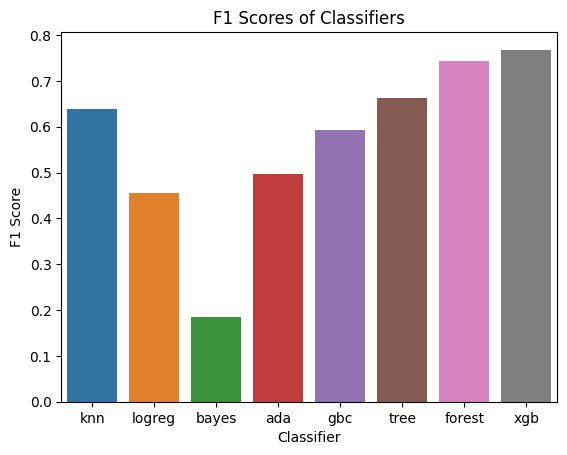

In [33]:
df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1 Score'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'Classifier'}, inplace=True)
sns.barplot(data=df, x='Classifier', y='F1 Score')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Classifiers')
plt.show()

** Standarization/normalization does not improve scores.

### Performance on other image

In [37]:
sections = sectioning_valid(clahe(X[1]), N)
X_new = np.zeros((sections.shape[0], num_features))

for i in range(sections.shape[1]):
    X_new[i] = extract_features(sections[i])

_, y_new = cv2.threshold(y[0], 128, 1, cv2.THRESH_BINARY)
y_new = y_new.flatten()

512 512


In [38]:
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)
y_pred_new = xgb_clf.predict(X_new)

In [39]:
print(f'Train set: \n {classification_report(y_pred_train, y_train)}')
print('------------------------------------------------------\n')
print(f'Test set: \n {classification_report(y_pred_test, y_test)}')
print('------------------------------------------------------\n')
print(f'Different image: \n{classification_report(y_pred_new, y_new)}')

Train set: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    585869
           1       0.71      0.89      0.79     43276

    accuracy                           0.97    629145
   macro avg       0.85      0.93      0.89    629145
weighted avg       0.97      0.97      0.97    629145

------------------------------------------------------

Test set: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    146467
           1       0.69      0.87      0.77     10820

    accuracy                           0.96    157287
   macro avg       0.84      0.92      0.87    157287
weighted avg       0.97      0.96      0.97    157287

------------------------------------------------------

Different image: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    262141
           1       0.00      0.00      0.00         3

    accuracy               

In [40]:
y_new = y_new.reshape(img_size)
y_pred_new = y_pred_new.reshape(img_size)

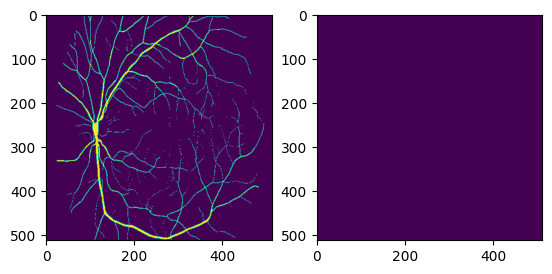

In [41]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y_new)
ax[1].imshow(y_pred_new)
plt.show()

In [ ]:
## Something is wrong with unseen image. Overfitting? :-c